In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re
import pandas as pd
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [2]:
# read dataset
tweets = pd.read_csv("../input/twitter-airline-sentiment/Tweets.csv")
tweets.head(4)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)


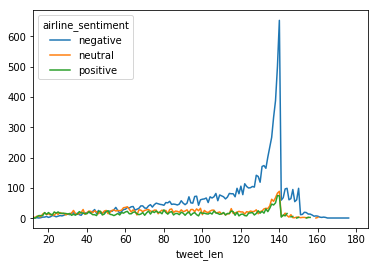

In [3]:
tweets['tweet_len'] = tweets['text'].apply(len)
tweets.groupby(['tweet_len', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

In [4]:
data = tweets[['text','airline_sentiment']]
print(data['airline_sentiment'][:10])
#cleaning data set. Consider only the positive and negative ones
data = data[data.airline_sentiment != 'neutral']
print(data['airline_sentiment'][:10])
print(data['text'][:10])

0    neutral 
1    positive
2    neutral 
3    negative
4    negative
5    negative
6    positive
7    neutral 
8    positive
9    positive
Name: airline_sentiment, dtype: object
1     positive
3     negative
4     negative
5     negative
6     positive
8     positive
9     positive
11    positive
12    positive
13    positive
Name: airline_sentiment, dtype: object
1     @VirginAmerica plus you've added commercials to the experience... tacky.                                                                    
3     @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse              
4     @VirginAmerica and it's a really big bad thing about it                                                                                     
5     @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA    
6     @VirginAmerica yes, nearly every time 

1     virginamerica plus youve added commercials to the experience tacky                                                                 
3     virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse            
4     virginamerica and its a really big bad thing about it                                                                              
5     virginamerica seriously would pay 30 a flight for seats that didnt have this playing\nits really the only bad thing about flying va
6     virginamerica yes nearly every time i fly vx this ear worm wont go away                                                            
8     virginamerica well i didntbut now i do d                                                                                           
9     virginamerica it was amazing and arrived an hour early youre too good to me                                                        
11    virginamerica i lt3 pretty g

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

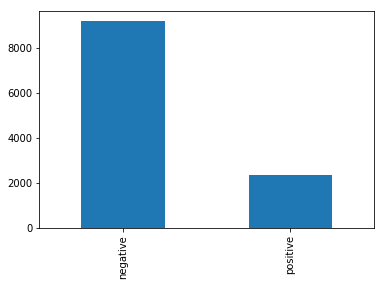

In [5]:
# cleaning data set
data['text'] = data['text'].apply(lambda x: x.lower()) # convert all to lower
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # remove anything except alphanumeric
print(data['text'][:10])
data['airline_sentiment'].value_counts().plot(kind='bar')
data['airline_sentiment'].value_counts()

In [6]:
#tokenization

mnax_words = 1500
tokenizer = Tokenizer(num_words=mnax_words, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
# print('Tokenized sentences', X[:5])
X = pad_sequences(X)
# print(X[:5])

In [7]:
enbedding_out_dim = 256
lstm_out_dim = 256

model = Sequential()
model.add(Embedding(mnax_words, enbedding_out_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out_dim))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 256)           384000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 909,826
Trainable params: 909,826
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# data set to train
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 50)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9232, 32) (9232, 2)
(2309, 32) (2309, 2)


In [9]:
X_val = X_train[:500]
Y_val = Y_train[:500]

In [10]:
partial_X_train = X_train[500:]
partial_Y_train = Y_train[500:]

In [11]:
# train the net
batch_size = 512
history = model.fit(X_train,Y_train, 
                    epochs = 20, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9232 samples, validate on 500 samples
Epoch 1/20
9232/9232 [==============================] - 2s 240us/step - loss: 0.4955 - accuracy: 0.7955 - val_loss: 0.3708 - val_accuracy: 0.8360
Epoch 2/20
9232/9232 [==============================] - 1s 80us/step - loss: 0.3192 - accuracy: 0.8637 - val_loss: 0.2417 - val_accuracy: 0.9080
Epoch 3/20
9232/9232 [==============================] - 1s 81us/step - loss: 0.2090 - accuracy: 0.9191 - val_loss: 0.1652 - val_accuracy: 0.9460
Epoch 4/20
9232/9232 [==============================] - 1s 80us/step - loss: 0.1599 - accuracy: 0.9380 - val_loss: 0.1347 - val_accuracy: 0.9540
Epoch 5/20
9232/9232 [==============================] - 1s 81us/step - loss: 0.1348 - accuracy: 0.9498 - val_loss: 0.1064 - val_accuracy: 0.9700
Epoch 6/20
9232/9232 [==============================] - 1s 78us/step - loss: 0.1202 - accuracy: 0.9534 - val_loss: 0.0995 - val_accuracy: 0.9740
Epoch 7/20
9232/9232 [==============================] - 1s 88us/step - loss: 0.112

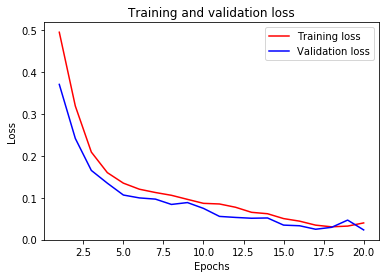

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# validation
positive_count, negative_count, positive_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):

    result = model.predict(X_val[x].reshape(1, X_test.shape[1]), batch_size=1)[0]

    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            positive_correct += 1

    if np.argmax(Y_val[x]) == 0:
        negative_count += 1
    else:
        positive_count += 1
print("positive accuracy", positive_correct / positive_count * 100, "%")
print("negative accuracy", neg_correct / negative_count * 100, "%")

positive accuracy 98.13084112149532 %
negative accuracy 99.74554707379136 %
